In [67]:
import os
import scanpy as sc
import numpy as np
import torch
from torch_geometric.data import Data, Dataset
import rootutils
rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)
from src.data.spatial_omics_datamodule import SpatialOmicsDataModule
from src.models.bgrl_module import BGRLLitModule
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score

In [68]:
datamodule = SpatialOmicsDataModule(data_dir="../data/domain/raw", processed_dir="../data/domain/processed")
datamodule.prepare_data()
datamodule.setup()
test_dataloder = datamodule.test_dataloader()

for batch in test_dataloder:
    print(batch.sample_name[0])

BaristaSeq1
MERFISH_small1
STARmap4
STARmap2
STARmap3
MERFISH_small5
MERFISH_small4
STARmap1
BaristaSeq3
MERFISH_small3
MERFISH_small2
BaristaSeq2


In [69]:
desired_sample_name = "MERFISH_small5"
batch = None

for b in test_dataloder:
    if b.sample_name[0] == desired_sample_name:
        batch = b
        break

print(batch)
print(batch.sample_name)

DataBatch(x=[5543, 50], edge_index=[2, 62250], edge_weight=[62250], sample_name=[1], batch=[5543], ptr=[2])
['MERFISH_small5']


In [70]:
checkpoint_path = "../logs/train_domain/runs/2025-03-28_12-17-28/checkpoints/epoch_256.ckpt"
model = BGRLLitModule.load_from_checkpoint(checkpoint_path).net.online_encoder
model

/Users/michel/miniconda3/envs/augmentation/lib/python3.9/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


TwoLayerGCN(
  (conv1): GCNConv(50, 32)
  (conv2): GCNConv(32, 16)
)

In [71]:
with torch.no_grad():
    node_embeddings = model(batch.x, batch.edge_index, batch.edge_weight)
node_embeddings.shape

torch.Size([5543, 16])

In [72]:
adata = sc.read_h5ad("../data/domain/processed/MERFISH_small5.h5ad")
adata

AnnData object with n_obs × n_vars = 5543 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes'
    var: 'n_cells', 'mean', 'std'
    uns: 'domain_colors', 'log1p', 'pca'
    obsm: 'X_pca', 'adj', 'spatial'
    varm: 'PCs'

In [77]:
cell_embeddings_np = node_embeddings.cpu().numpy()
adata.obsm["cell_embeddings"] = cell_embeddings_np
adata

AnnData object with n_obs × n_vars = 5543 × 155
    obs: 'cell_class', 'neuron_class', 'domain', 'Region', 'n_genes', 'leiden'
    var: 'n_cells', 'mean', 'std'
    uns: 'domain_colors', 'log1p', 'pca', 'neighbors', 'leiden', 'Region_colors', 'leiden_colors'
    obsm: 'X_pca', 'adj', 'spatial', 'cell_embeddings'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [74]:

sc.pp.neighbors(adata, use_rep="cell_embeddings")  # Build the neighborhood graph
sc.tl.leiden(adata, resolution=0.17)  # Perform Leiden clustering
print(adata.obs["leiden"])

Unnamed: 0
-3749x-3749    7
-3746x-3742    7
-3743x-3791    7
-3738x-3773    7
-3736x-3896    3
              ..
-2149x-2317    3
-2139x-2307    3
-2006x-2318    3
-2121x-2317    3
-1985x-2116    3
Name: leiden, Length: 5543, dtype: category
Categories (9, object): ['0', '1', '2', '3', ..., '5', '6', '7', '8']


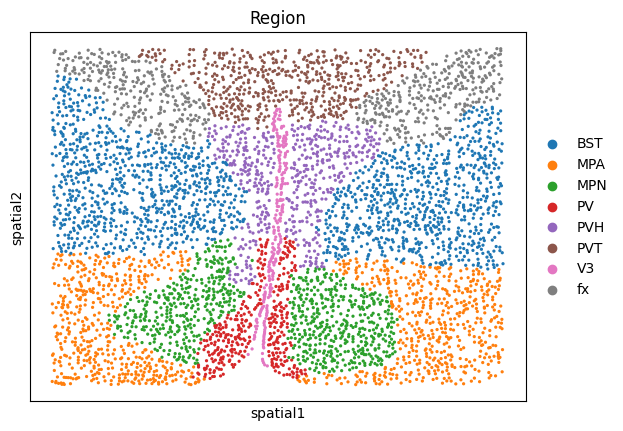

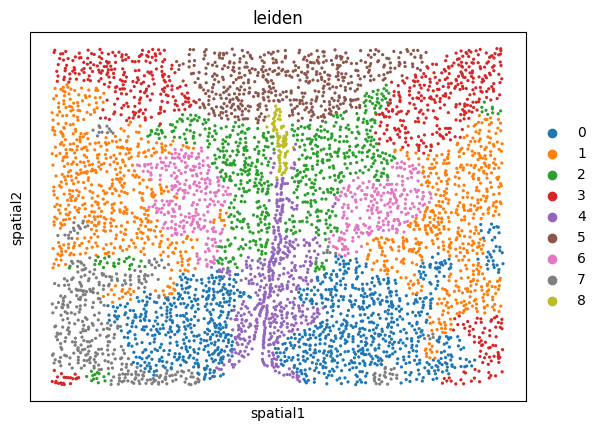

In [75]:
sc.pl.embedding(adata, basis="spatial", color="Region")
sc.pl.embedding(adata, basis="spatial", color="leiden")

In [76]:
# Ground truth labels
ground_truth_labels = adata.obs["Region"]

# Leiden clustering labels
leiden_labels = adata.obs["leiden"]

# Compute NMI
nmi = normalized_mutual_info_score(ground_truth_labels, leiden_labels)
print(f"Normalized Mutual Information (NMI): {nmi:.4f}")

# Compute ARI
ari = adjusted_rand_score(ground_truth_labels, leiden_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

Normalized Mutual Information (NMI): 0.5818
Adjusted Rand Index (ARI): 0.4345
